In [6]:
# Fix imports when running from notebooks/ folder
import sys
from pathlib import Path

project_root = Path.cwd().parent 
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print(f"Added to path: {project_root}")

%load_ext autoreload
%autoreload 2

Added to path: /Users/elshaday/DEV/10Academy/customer-experience-analytics-week2
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from src.data import DataManager
from tabulate import tabulate
from scripts import analyze_bank_themes
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud


plt.rcParams["figure.figsize"] = (10, 6)

In [8]:
dm = DataManager()
df = dm.load_data()

In [ ]:
print("Driver and Pain Points per bank:")

banks = sorted(df["bank"].unique())
bank_insights = {}

for bank in banks:
    df_bank = df[df["bank"] == bank]
    bank_insights[bank] = analyze_bank_themes(df_bank)

# quick print summary
for bank, info in bank_insights.items():
    print(f"\n=== {bank} ===")
    print("Total reviews:", info["total_reviews"])
    print("Top drivers (theme - count - mean_vader):")
    if not info["drivers"].empty:
        print(tabulate(info["drivers"][["theme", "count", "mean_vader"]], headers='keys', tablefmt="grid"))
    else:
        print("  (no driver candidates with min_count threshold)")
    print("\nTop pain points (theme - count - mean_vader):")
    if not info["pain_points"].empty:
        print(
            tabulate(
                info["pain_points"][["theme", "count", "mean_vader"]],
                headers="keys",
                tablefmt="grid",
            )
        )

    else:
        print("(no pain candidates with min_count threshold)")

Driver and Pain Points per bank:

=== boa ===
Total reviews: 573
Top drivers (theme - count - mean_vader):
+----+-------------------------------+---------+--------------+
|    | theme                         |   count |   mean_vader |
+====+===============================+=========+==============+
|  5 | User Interface & Experience   |     107 |    0.461572  |
+----+-------------------------------+---------+--------------+
|  3 | Other                         |     264 |    0.137473  |
+----+-------------------------------+---------+--------------+
|  4 | Transactions                  |      22 |   -0.0535909 |
+----+-------------------------------+---------+--------------+
|  0 | Account Access & Login        |      50 |   -0.057994  |
+----+-------------------------------+---------+--------------+
|  1 | App Performance & Reliability |     121 |   -0.145507  |
+----+-------------------------------+---------+--------------+

Top pain points (theme - count - mean_vader):
+----+--------

### Cross-Bank Comparison – Key Takeaways (Dec 2025)

| Rank | Bank   | Strengths                                      | Critical Weaknesses                        | Recommended 2026 Focus                     |
|------|--------|------------------------------------------------|--------------------------------------------|--------------------------------------------|
| 1    | **CBE**    | • Happiest users overall<br>• Fewest high-impact pain points<br>• Strong positive sentiment even in support themes | Minor login friction                       | Maintain excellence + add in-app chat      |
| 2    | **Dashen** | • Best perceived UI/UX in Ethiopia<br>• Very strong login experience | App performance & reliability still the #1 complaint (but less severe than BOA) | Fix crashes/loading → could dominate market |
| 3    | **BOA**    | • Decent UI praise                              | **Clear #1 problem child**<br>→ 121 reviews about crashes, freezes, slow loading | Urgent performance overhaul needed         |

**Conclusion in one sentence:**
> CBE currently delivers the best day-to-day mobile banking experience, Dashen wins on modern UI and login flow, but BOA is dragged down by severe app stability issues that affect twice as many users as its competitors.

### Bonus: Quick code to generate this table automatically

Add this to your notebook after you have `bank_insights`:

```python
# === AUTOMATIC BANK COMPARISON TABLE ===


In [20]:
comparison = []
for bank, data in bank_insights.items():
    # Safely get top driver
    if not data["drivers"].empty:
        d = data["drivers"].iloc[0]
        top_driver = f"{d['theme']}\n({int(d['count'])} rev, {d['mean_vader']:+.2f})"
    else:
        top_driver = "—"

    # Safely get top pain point
    if not data["pain_points"].empty:
        p = data["pain_points"].iloc[0]
        top_pain = f"{p['theme']}\n({int(p['count'])} rev, {p['mean_vader']:+.2f})"
    else:
        top_pain = "—"

    comparison.append([bank.upper(), data["total_reviews"], top_driver, top_pain])

# Beautiful output
print(
    tabulate(
        comparison,
        headers=["Bank", "Total Reviews", "Top Driver", "Top Pain Point"],
        tablefmt="grid",
    )
)

+--------+-----------------+-----------------------------+-------------------------------+
| Bank   |   Total Reviews | Top Driver                  | Top Pain Point                |
+========+=================+=============================+===============================+
| BOA    |             573 | User Interface & Experience | App Performance & Reliability |
|        |                 | (107 rev, +0.46)            | (121 rev, -0.15)              |
+--------+-----------------+-----------------------------+-------------------------------+
| CBE    |             567 | User Interface & Experience | Account Access & Login        |
|        |                 | (171 rev, +0.49)            | (19 rev, +0.07)               |
+--------+-----------------+-----------------------------+-------------------------------+
| DASHEN |             582 | User Interface & Experience | App Performance & Reliability |
|        |                 | (171 rev, +0.62)            | (64 rev, -0.06)               |

In [11]:
print("Suggestions and Improvements:")

def suggest_improvements(pain_df):
    suggestions = []
    for _, row in pain_df.iterrows():
        theme = row["theme"]
        # template rules
        if (
            "login" in theme.lower()
            or "access" in theme.lower()
            or "otp" in theme.lower()
        ):
            suggestions.append(
                f"Improve authentication flow: reduce OTP delays, add fallback/clearer errors for {theme}."
            )
        elif (
            "transfer" in theme.lower()
            or "transaction" in theme.lower()
            or "payment" in theme.lower()
        ):
            suggestions.append(
                f"Hardening transactions: improve retry/visibility for {theme}, add clearer failure messages and receipts."
            )
        elif (
            "crash" in theme.lower()
            or "slow" in theme.lower()
            or "loading" in theme.lower()
        ):
            suggestions.append(
                f"Performance & reliability: investigate errors and reduce app crashes and slow-loading screens related to {theme}."
            )
        elif "support" in theme.lower() or "service" in theme.lower():
            suggestions.append(
                f"Customer support improvements: shorten SLA, add in-app support channels and status updates for {theme}."
            )
        else:
            suggestions.append(
                f"Investigate '{theme}' for targeted UX improvements and clearer messaging."
            )
    # dedupe and limit
    uniq = []
    for s in suggestions:
        if s not in uniq:
            uniq.append(s)
    return uniq[:5]


# gather per bank
for bank, info in bank_insights.items():
    improvements = suggest_improvements(info["pain_points"])
    print(f"\nSuggested improvements for {bank}:")
    for i, imp in enumerate(improvements[:5], 1):
        print(f"{i}. {imp}")

Suggestions and Improvements:

Suggested improvements for boa:
1. Investigate 'App Performance & Reliability' for targeted UX improvements and clearer messaging.
2. Improve authentication flow: reduce OTP delays, add fallback/clearer errors for Account Access & Login.
3. Hardening transactions: improve retry/visibility for Transactions, add clearer failure messages and receipts.
4. Investigate 'Other' for targeted UX improvements and clearer messaging.
5. Investigate 'User Interface & Experience' for targeted UX improvements and clearer messaging.

Suggested improvements for cbe:
1. Improve authentication flow: reduce OTP delays, add fallback/clearer errors for Account Access & Login.
2. Investigate 'App Performance & Reliability' for targeted UX improvements and clearer messaging.
3. Customer support improvements: shorten SLA, add in-app support channels and status updates for Customer Support & Feature Requests.
4. Hardening transactions: improve retry/visibility for Transactions, ad

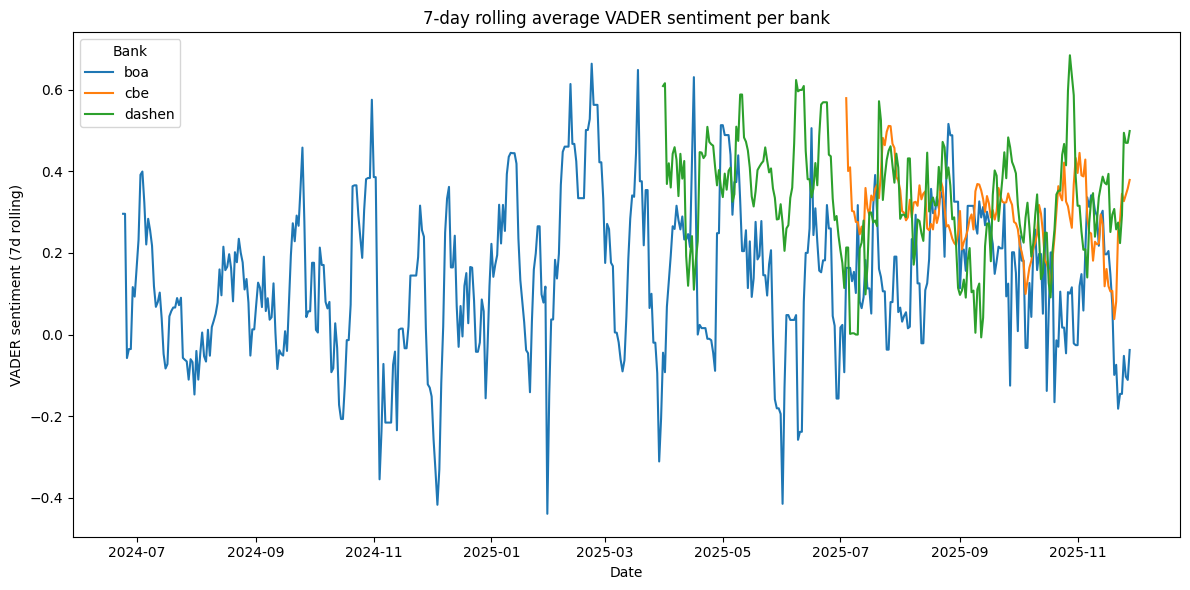

In [12]:
# prepare daily average per bank
df_time = (
    df.set_index("date")
    .groupby("bank")["vader_score"]
    .resample("D")
    .mean()
    .reset_index()
)
# rolling 7-day mean
df_time["vader_7d"] = df_time.groupby("bank")["vader_score"].transform(
    lambda s: s.rolling(7, min_periods=1).mean()
)

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_time, x="date", y="vader_7d", hue="bank")
plt.title("7-day rolling average VADER sentiment per bank")
plt.xlabel("Date")
plt.ylabel("VADER sentiment (7d rolling)")
plt.legend(title="Bank")
plt.tight_layout()
plt.show()

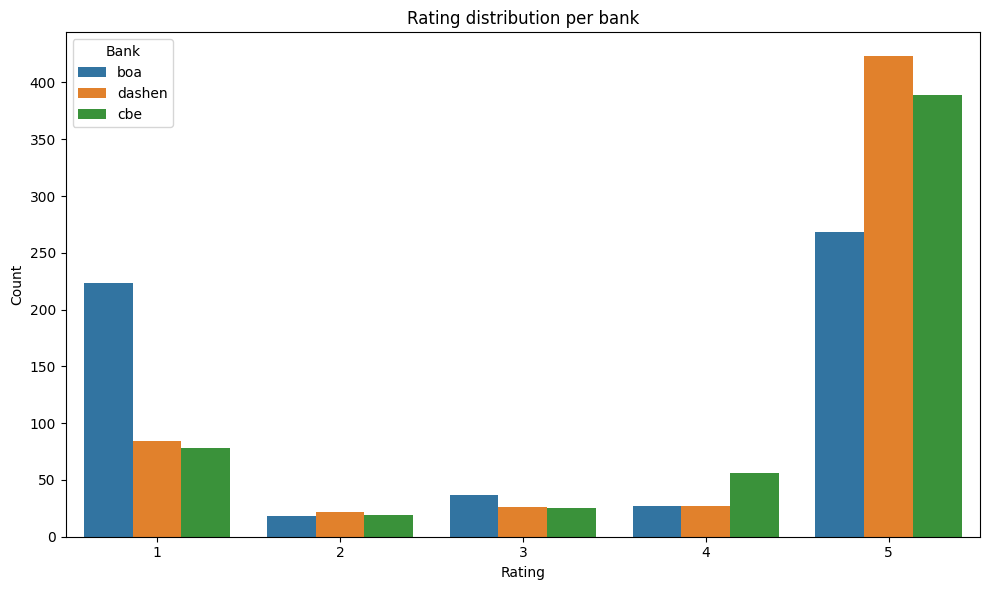

In [13]:
plt.figure(figsize=(10, 6))
sns.countplot(
    data=df, x="rating", hue="bank", order=sorted(df["rating"].dropna().unique())
)
plt.title("Rating distribution per bank")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.legend(title="Bank")
plt.tight_layout()
plt.show()

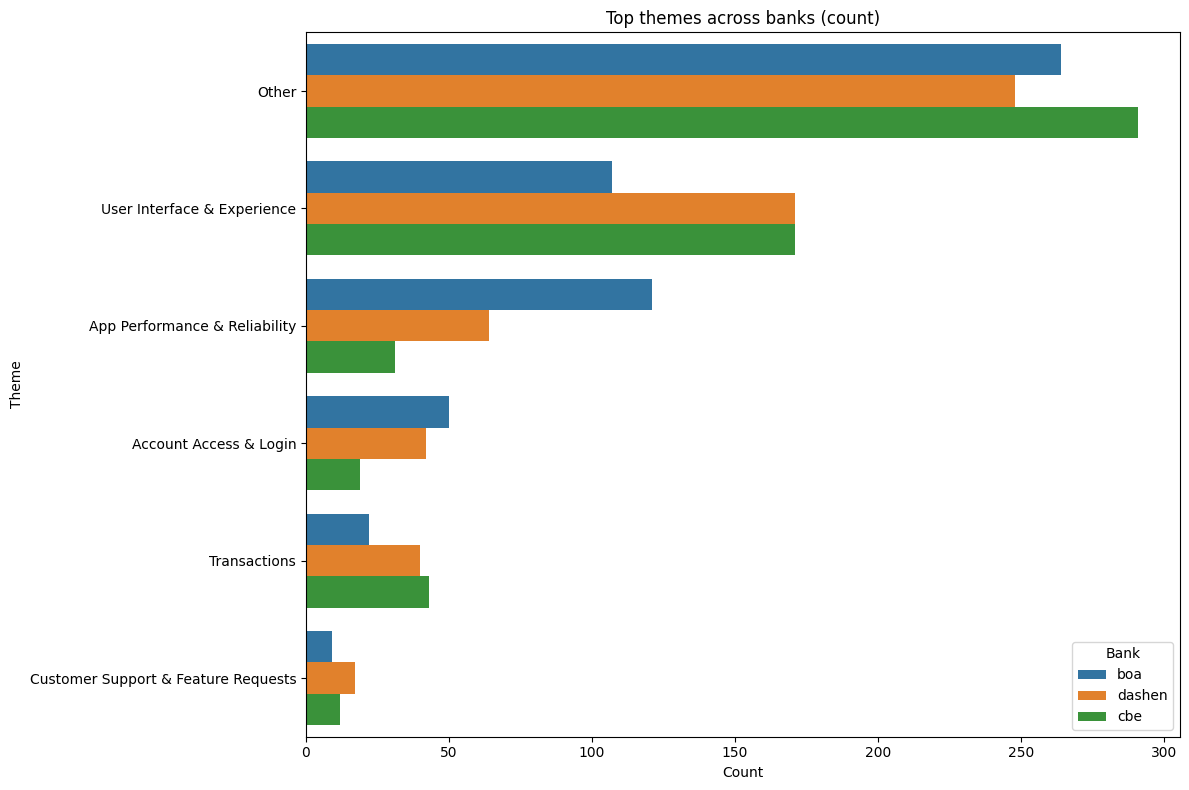

In [14]:
# overall top themes
top_themes = df["theme"].value_counts().nlargest(15).index.tolist()
df_top = df[df["theme"].isin(top_themes)]
plt.figure(figsize=(12, 8))
sns.countplot(data=df_top, y="theme", hue="bank", order=top_themes)
plt.title("Top themes across banks (count)")
plt.xlabel("Count")
plt.ylabel("Theme")
plt.legend(title="Bank")
plt.tight_layout()
plt.show()

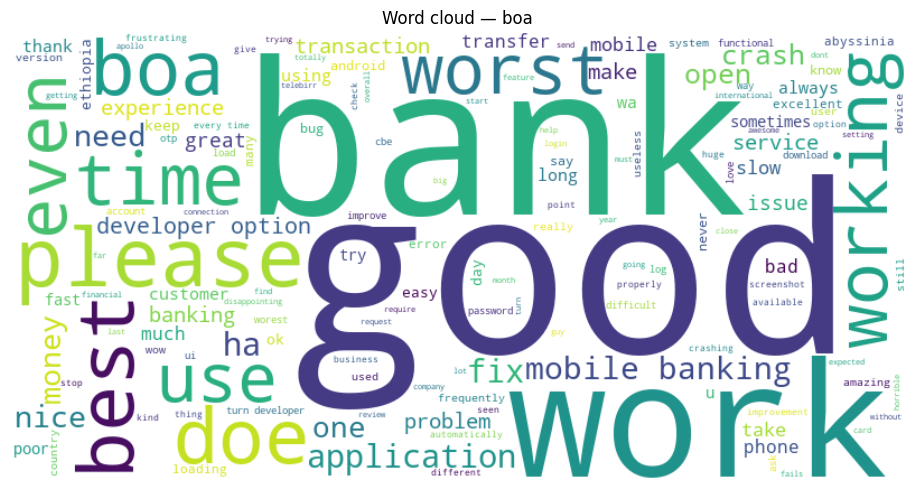

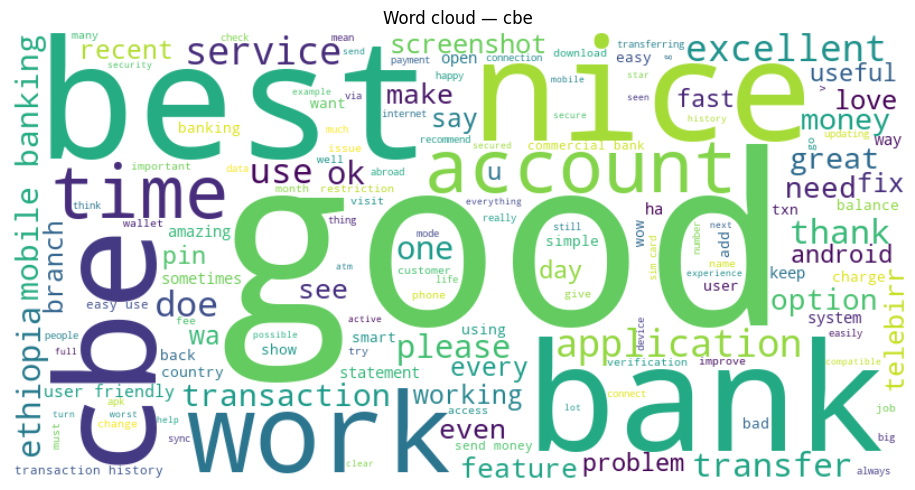

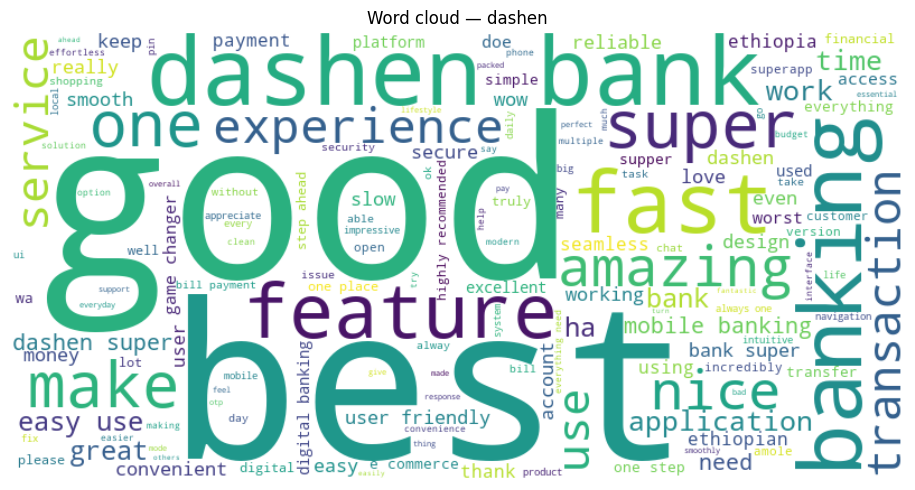

In [15]:
for bank in banks:
    text = " ".join(
        df.loc[df["bank"] == bank, "clean_review"].dropna().astype(str).tolist()
    )
    if not text.strip():
        continue
    wc = WordCloud(
        width=800, height=400, background_color="white", max_words=150
    ).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word cloud — {bank}")
    plt.tight_layout()
    plt.show()

1. Strong negative review skew: App store/play store reviews are voluntary and self-selected. Users are ~5–10× more likely to leave a review when frustrated than when satisfied.Thus, Pain points such as crashes and login issues appear disproportionately large.

2. Language & sentiment model bias: VADER and TextBlob were trained primarily on English Twitter/data. Many reviews contain Amharic, Afaan Oromo, Tigrinya, or heavy code-switching. Non-English reviews were dropping resulting in an analysis that does not represent local formats. Some comments contained names of users which was wrongly ranked high by TF-IDF due to low occurances.

3. Theme labelling bias: Themes were assigned by a (semi-)automated topic model & keyword rules. Some reviews are misclassified (e.g., “OTP not coming” labelled as “Transactions” instead of “Login”), causing distortion of driver/pain-point ranking, but does not invalidate the big picture.

4. Demographic bias: app reviewers may not reflect the bank’s full user base (urban, younger, or more tech-savvy users are over-represented)